In [23]:
import cv2
import numpy as np
import seaborn as sns
import pandas as pd
from skimage.feature import hog
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import os

# Load CSV file with labels
label_df = pd.read_csv('APS360_Project_Dataset/dataset1/bank_card_images_train_labels.csv', dtype={'card_number': str})
label_df.columns = ['index', 'card_number', 'Nimportant1', 'Nimportant2', 'expiration', 'name']  

# Folder path for card images
image_folder = 'APS360_Project_Dataset/dataset1/bank_card_images_train'

In [3]:
# Function to preprocess each card image and segment digits
def preprocess_and_segment_digits(image):
    # Convert to grayscale and apply binary threshold
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    threshold_value, binary_image = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    
    # Find contours and filter based on contour size
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    digit_contours = [cnt for cnt in contours if cv2.boundingRect(cnt)[2] > 10]  # Filter out small contours, only keep contours with width > 10 pixels
    
    # Sort contours from left to right
    digit_contours = sorted(digit_contours, key=lambda x: cv2.boundingRect(x)[0])
    
    # Segment each digit
    digit_images = []
    for cnt in digit_contours:
        x, y, w, h = cv2.boundingRect(cnt)
        digit_image = binary_image[y:y+h, x:x+w]
        digit_image = cv2.resize(digit_image, (32, 32))  # Resize to a standard size
        digit_images.append(digit_image)
    
    return digit_images  # List of images, each containing a single digit

# Function to extract HOG features from a list of digit images
def extract_hog_features(images):
    hog_features = []
    for img in images:
        feature = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
        hog_features.append(feature)
    return np.array(hog_features)


In [36]:
# Initialize lists to store full card number sequences and digit-level data
y_true_sequences = []       # True sequences (full card numbers)
y_pred_sequences = []       # Predicted sequences (full card numbers, populated after prediction)
all_digit_pred = []         # Predicted digit images (individual digits)
all_digit_labels = []       # True digit labels (individual digits)

# Loop through each image and label in the dataset
for index, row in label_df.iterrows():
    # Check for missing card number and skip if missing
    card_number = str(int(row['card_number'])) if pd.notna(row['card_number']) else None
    if card_number is None:
        print(f"Warning: Skipped row {index} due to missing card number.")
        continue
    
    # Convert card_number to a string with only digits (removes any non-numeric characters)
    card_number = ''.join(filter(str.isdigit, card_number))
    y_true_sequences.append(card_number)  # Add to true sequence list

    # Read and preprocess the image
    image_path = os.path.join(image_folder, row['index'])
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image at {image_path}")
        continue

    # Preprocess image and segment digits
    digit_images = preprocess_and_segment_digits(image)
    
    # Allow partial matching if segmentation count doesn't match expected length
    min_length = min(len(digit_images), len(card_number))

    if min_length > 0:
        predicted_digits = []
        for i in range(min_length):
            digit_img = digit_images[i]
            predicted_digits.append(digit_img)         # Store each segmented digit image
            all_digit_pred.append(digit_img)           # Keep for digit-level analysis
            all_digit_labels.append(int(card_number[i])) # Corresponding true label

        # Form the predicted sequence from available segmented digits
        label_of_predicted_digits_length = ''.join([str(int(card_number[i])) for i in range(min_length)])
        y_pred_sequences.append(label_of_predicted_digits_length)

        print(f"Processed card number (partial match allowed): True = {card_number}, Predicted = {label_of_predicted_digits_length}")

    else:
        print(f"Warning: No valid segments for {image_path}, skipped.")


Processed card number (partial match allowed): True = 62257583, Predicted = 62257583
Processed card number (partial match allowed): True = 62257583, Predicted = 62257583
Processed card number (partial match allowed): True = 62257583, Predicted = 622575
Processed card number (partial match allowed): True = 62257583, Predicted = 62257583
Processed card number (partial match allowed): True = 62257583, Predicted = 62257583
Processed card number (partial match allowed): True = 62257583, Predicted = 62257583
Processed card number (partial match allowed): True = 62257583, Predicted = 62257583
Processed card number (partial match allowed): True = 62257583, Predicted = 62257583
Processed card number (partial match allowed): True = 62257583, Predicted = 622575
Processed card number (partial match allowed): True = 62257583, Predicted = 62257583
Processed card number (partial match allowed): True = 62257583, Predicted = 62257583
Processed card number (partial match allowed): True = 62257583, Predi

In [50]:
# X contains HOG features for each digit image, y contains the true labels (digits)
X = extract_hog_features(all_digit_pred)  # HOG features
y = np.array(all_digit_labels)            # True digit labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=30)

# Initialize and train the KNN model
k = 6  # Number of neighbors, can experiment with different values
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train, y_train)

# Optionally, evaluate the model on the test set to check accuracy
test_accuracy = knn_model.score(X_test, y_test)
print(f"KNN Test Accuracy: {test_accuracy * 100:.2f}%")

KNN Test Accuracy: 34.74%


Test Accuracy: 34.74%
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         6
           2       0.28      0.35      0.31       111
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         2
           5       0.26      0.33      0.29        70
           6       0.62      0.61      0.62       105
           7       0.14      0.08      0.10        36
           8       0.25      0.19      0.22        58
           9       0.00      0.00      0.00         1

    accuracy                           0.35       403
   macro avg       0.16      0.16      0.15       403
weighted avg       0.33      0.35      0.34       403



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


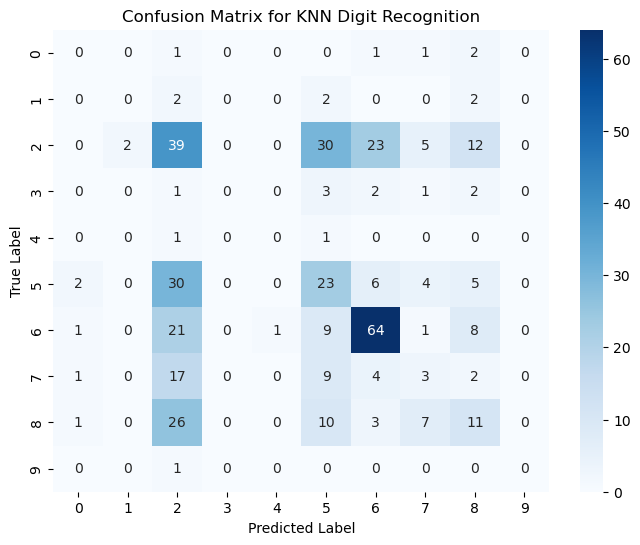

In [52]:
# Predict on the test set
y_pred = knn_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Print a detailed classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for KNN Digit Recognition")
plt.show()


In [53]:
# Function to predict a full card number sequence
def predict_card_number(digit_images, knn_model):
    predicted_digits = []
    
    for digit_img in digit_images:
        # Extract HOG features for the digit image
        hog_feature = extract_hog_features([digit_img])[0]  # Get the first element since it's a single image

        # Use KNN model to predict the digit
        predicted_digit = knn_model.predict([hog_feature])[0]  # Predict and get the digit label
        predicted_digits.append(str(predicted_digit))

    # Combine all predicted digits to form the card number
    predicted_card_number = ''.join(predicted_digits)
    return predicted_card_number

# Example usage for a new card image
# Assuming `digit_images` is a list of segmented digit images from a single card image
# digit_images = preprocess_and_segment_digits(new_card_image)
# predicted_card_number = predict_card_number(digit_images, knn_model)
# print(f"Predicted Card Number: {predicted_card_number}")



Predicted Card Number: 6225
